In [10]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [11]:
def get_data(data_path,label_path):
    
    data_list = os.listdir(data_path)
    label_list = os.listdir(label_path)
#     num = min(len(data_list),len(label_list))
    num = 1000
    
    X_all = []
    y_all = []

    for i in range(num):
        print("Processing: ",i+1,"/",num)
        clear_output(wait=True)

#         img = cv2.imread(data_path+data_list[i],cv2.IMREAD_COLOR)
        img= cv2.imdecode(np.fromfile(data_path+data_list[i], dtype=np.uint8), cv2.IMREAD_COLOR)

#         label = cv2.imread(label_path+label_list[i],cv2.IMREAD_GRAYSCALE)
        label = cv2.imdecode(np.fromfile(label_path+label_list[i], dtype=np.uint8), cv2.IMREAD_GRAYSCALE)


        X_all.append(img)
        y_all.append(label)
        
    print("Spliting..")
    clear_output(wait=True)

    X_all = np.array(X_all)/255
    y_all = np.array(y_all)/255
    
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=1234)
    
    print("Done!")
    
    return X_train, X_test, y_train, y_test

In [12]:
data_path = './data_processed/unet_data/'
label_path = './data_processed/unet_label/'

X_train, X_test, y_train, y_test = get_data(data_path,label_path)

Done!


In [13]:
keras.backend.clear_session()
model = keras.models.load_model('./unet.h5')
# model.summary()

In [14]:
y_pres = model.predict(X_test)
y_pres.shape

(300, 512, 512, 1)

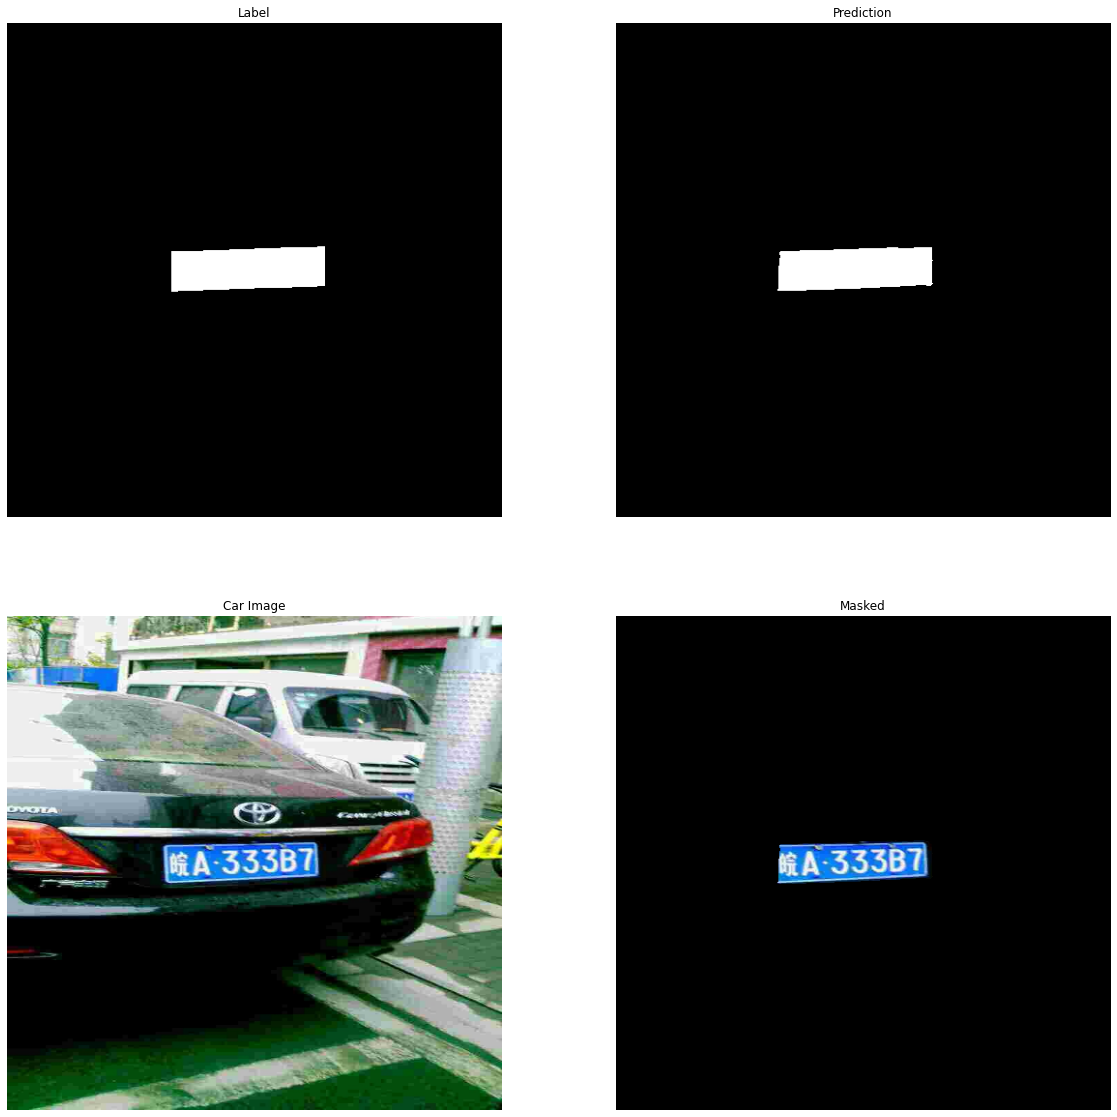

In [15]:
import random
i = random.randint(0,len(y_pres))

y_o = (y_test[i]*255).astype('uint8')
y_p = (y_pres[i]*255).astype('uint8')
img = (X_test[i]*255).astype('uint8')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ret,y_p = cv2.threshold(y_p,127,255,cv2.THRESH_BINARY)

y_p_mask = np.array(y_p)
masked = cv2.bitwise_and(img_rgb, img_rgb, mask=y_p_mask)


fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(y_o,cmap='gray')
ax1.set_title("Label")
ax1.axis('off')

ax2 = fig.add_subplot(2,2,2)
ax2.set_title("Prediction")
ax2.imshow(y_p,cmap='gray')
ax2.axis('off')

ax3 = fig.add_subplot(2,2,3)
ax3.set_title("Car Image")
ax3.imshow(img_rgb)
ax3.axis('off')

ax4 = fig.add_subplot(2,2,4)
ax4.set_title("Masked")
ax4.imshow(masked)
ax4.axis('off')

plt.show()

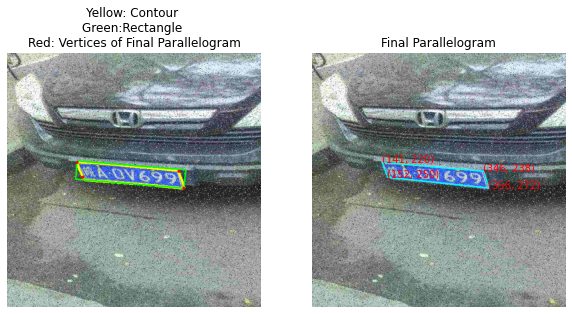

In [52]:
import random
i = random.randint(0,len(y_pres))

y_p = (y_pres[i]*255).astype('uint8')
img = (X_test[i]*255).astype('uint8')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ret,y_p = cv2.threshold(y_p,127,255,cv2.THRESH_BINARY)
y_p_mask = np.array(y_p)

contours, hierarchy = cv2.findContours(y_p_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
draw_img = cv2.drawContours(img_rgb.copy(), contours, -1, (255, 255, 0), 3)

cont = contours[0]

rect = cv2.minAreaRect(cont)
box = cv2.boxPoints(rect).astype(np.int32)
r = cv2.drawContours(draw_img.copy(), [box], 0, (0, 255, 0), 2)

box_cont = []
cont_temp = cont.reshape(len(cont),2)
for b in box:
    min_dist = 100000
    for i,p in enumerate(cont_temp):
        d = (b[0]-p[0])**2 + (b[1]-p[1])**2
        if d < min_dist:
            min_dist = d
            pick = p
            index = i
    box_cont.append(pick)
    cont_temp = np.delete(cont_temp,index,0)

for b in box_cont:
    cv2.circle(r,(b[0],b[1]),3,(255,0,0),-1)

r1 = cv2.drawContours(img_rgb.copy(),[np.array(box_cont)], 0, (0, 255, 255), 2)

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(r)
ax1.axis('off')
ax1.set_title("Yellow: Contour \nGreen:Rectangle \nRed: Vertices of Final Parallelogram")

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(r1)
ax2.axis('off')
ax2.set_title("Final Parallelogram")

for b in box_cont:
    ax2.text(b[0],b[1],(b[0],b[1]),color='r')
plt.show()

In [55]:
p = np.array(box_cont)
p = p[np.argsort(p[:,0])]
p_l = p[:2]
p_r = p[2:]
p_lu,p_ld = p_l[np.argsort(p_l[:,1])]
p_ru,p_rd = p_r[np.argsort(p_r[:,1])]

In [56]:
box_from = np.float32([p_lu,p_ld,p_ru,p_rd])
box_to = np.float32([(0,0),(0,80),(240,0),(240,80)])
trans_mat=cv2.getPerspectiveTransform(box_from,box_to)
aligned_plate=cv2.warpPerspective(img_rgb,trans_mat,(240,80))

x, y, w, h = cv2.boundingRect(cont)  
unaligned_plate = img_rgb[y:y+h,x:x+w]

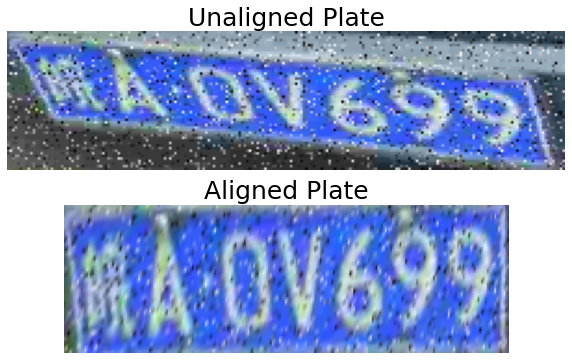

In [66]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(211)
ax1.imshow(unaligned_plate)
ax1.set_title('Unaligned Plate',fontsize=25)
ax1.axis('off')

ax2 = fig.add_subplot(212)
ax2.imshow(aligned_plate)
ax2.set_title('Aligned Plate',fontsize=25)
ax2.axis('off')

plt.show()

In [561]:
aligned_plate=cv2.warpPerspective(img,trans_mat,(240,80))
cv2.imwrite("./test.png",aligned_plate)

True

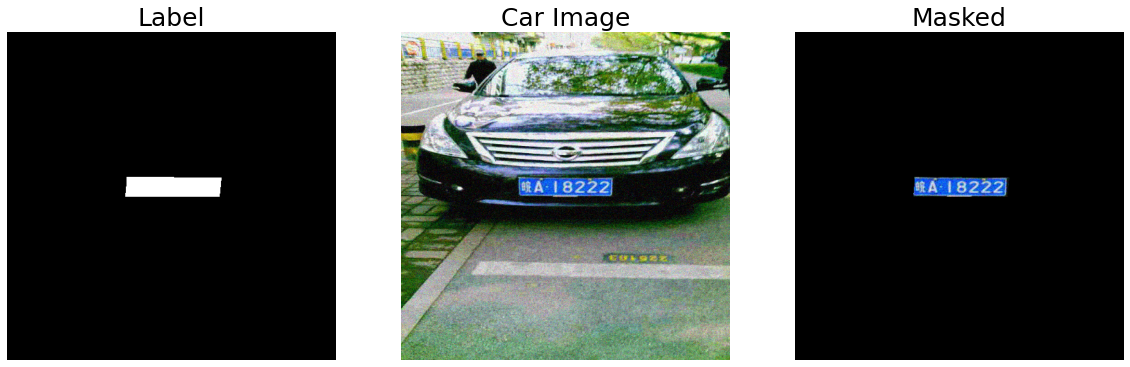

In [8]:
import random
i = random.randint(0,len(y_pres))

y_o = (y_test[i]*255).astype('uint8')
# y_p = (y_pres[i]*255).astype('uint8')
img = (X_test[i]*255).astype('uint8')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ret,y_p = cv2.threshold(y_p,127,255,cv2.THRESH_BINARY)

y_o_mask = np.array(y_o)
masked = cv2.bitwise_and(img_rgb, img_rgb, mask=y_o_mask)


fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(y_o,cmap='gray')
ax1.set_title("Label",fontsize=25)
ax1.axis('off')

# ax2 = fig.add_subplot(2,2,2)
# ax2.set_title("Prediction")
# ax2.imshow(y_p,cmap='gray')
# ax2.axis('off')

ax3 = fig.add_subplot(1,3,2)
ax3.set_title("Car Image",fontsize=25)
ax3.imshow(img_rgb)
ax3.axis('off')

ax4 = fig.add_subplot(1,3,3)
ax4.set_title("Masked",fontsize=25)
ax4.imshow(masked)
ax4.axis('off')

plt.show()